In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import os
import torch
import shutil


In [8]:
# create a data frame from the car data with the 
# following columns: image file, label

# get the list of files in the directory
files = os.listdir('car_data')
# create a data frame
df = pd.DataFrame(columns=['file', 'label'])


for carmake in ["Chevrolet", "Toyota", "Ford", "BMW"]:
    carmake_folder = os.path.join('car_folder', carmake)
    
    # Create the folder if it doesn't exist
    if not os.path.exists(carmake_folder):
        os.makedirs(carmake_folder)

for file in files:
    result = file.split('_')
    label = result[0]

    if label in ["Chevrolet", "Toyota", "Ford", "BMW"]:
        source_path = os.path.join('car_data', file)
        destination_folder = os.path.join('car_folder', label)
        destination_path = os.path.join(destination_folder, file)

        # Move the image to the respective folder
        shutil.move(source_path, destination_path)




In [10]:
# print the length of the BMW, chevrolet, ford, and toyota dataframes

print(len(os.listdir('car_folder/BMW')))
print(len(os.listdir('car_folder/Chevrolet')))
print(len(os.listdir('car_folder/Ford')))
print(len(os.listdir('car_folder/Toyota')))

4121
5079
4416
4598


In [28]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# get the data directory
data_dir = 'car_folder'

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the pixel values
])

dataset = ImageFolder(root=data_dir, transform=transform)





In [ ]:
labels_map = {
    0: "BMW",
    1: "Chevrolet",
    2: "Ford",
    3: "Toyota"
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


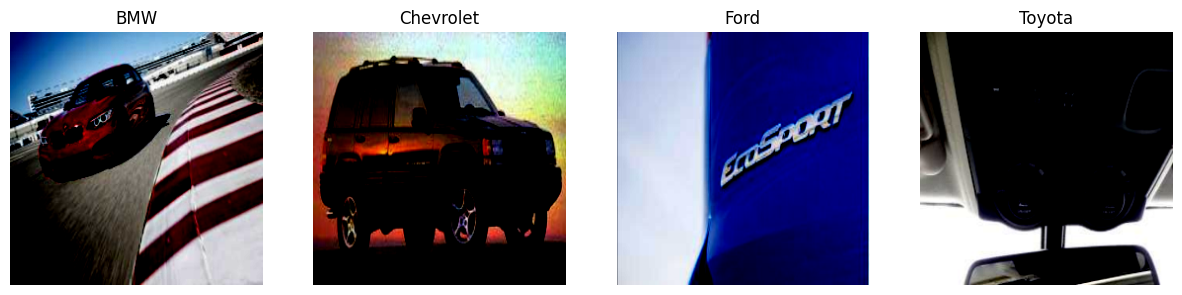

In [27]:
# TAKES A LONG TIME TO RUN(2 min)
sample_images = []

# Iterate over each class
for class_label in range(4):
    # Find the first image with the current class label
    for idx, (image, label) in enumerate(dataset):
        if label == class_label:
            sample_images.append((image, label))
            break

# Display one image from each class
fig, axs = plt.subplots(1, 4, figsize=(15, 15))

for i in range(4):
    ax = axs[i]
    ax.imshow(sample_images[i][0].permute(1, 2, 0))
    ax.set_title(labels_map[sample_images[i][1]])
    ax.axis('off')

plt.show()


In [36]:
# train test split
from torch.utils.data import random_split

# set the random seed
torch.manual_seed(0)
print(len(dataset), len(dataset)*0.8, len(dataset)*0.2)
# split the dataset
train_data, test_data = random_split(dataset, [14571, 3643])

# create a data loader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

18214 14571.2 3642.8


In [43]:

for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    print("Batch Shape - Inputs:", inputs.shape, " Targets:", targets.shape)
    break

for batch_idx, (inputs, targets) in enumerate(test_dataloader):
    print("Batch Shape - Inputs:", inputs.shape, " Targets:", targets.shape)
    break

Batch Shape - Inputs: torch.Size([32, 3, 256, 256])  Targets: torch.Size([32])
Batch Shape - Inputs: torch.Size([32, 3, 256, 256])  Targets: torch.Size([32])


In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [71]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(32768, 32),
    nn.ReLU(),
    nn.Linear(32, 4),
    nn.Softmax()
)
model.to(device)
print(model)


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=32768, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=4, bias=True)
  (10): Softmax(dim=None)
)


In [72]:
# hyper parameters

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [73]:
model.train()

losses = []
for epoch in range(epochs):
    # get the training accuracy
    correct = 0
    total = 0

    culm_loss = 0
    for batch_idx, batch_data in enumerate(train_dataloader):
        
        input = batch_data[0].to(device)
        y_pred= model(input)
        y_actual = batch_data[1].to(device)

        loss = criterion(y_pred, y_actual)
        culm_loss += loss.item()
        correct += (torch.argmax(y_pred, axis=1) == y_actual).sum().item()
        total += y_actual.size(0)

        model.zero_grad()
        loss.backward()

        optimizer.step()
    print(f'Epoch {epoch + 1}, loss = {culm_loss / len(train_dataloader)}, accuracy = {correct / total}')
    
    losses.append(loss.item())

Epoch 1, loss = 1.3033700368383474, accuracy = 0.3984626998833299
Epoch 2, loss = 1.1215136801464516, accuracy = 0.613821975156132
Epoch 3, loss = 1.0357739992047612, accuracy = 0.7038638391325235
Epoch 4, loss = 0.9800764165426555, accuracy = 0.7625420355500652
Epoch 5, loss = 0.9450119669761574, accuracy = 0.7976116944616019
Epoch 6, loss = 0.920086745238095, accuracy = 0.8232791160524329
Epoch 7, loss = 0.8989895105100515, accuracy = 0.8444169926566467
Epoch 8, loss = 0.8849777848574153, accuracy = 0.8582801454944753
Epoch 9, loss = 0.878066678188349, accuracy = 0.8649372040354129
Epoch 10, loss = 0.8699587617526975, accuracy = 0.8732413698442111
Epoch 11, loss = 0.8673205467169744, accuracy = 0.8763983254409443
Epoch 12, loss = 0.8615208495604364, accuracy = 0.8816827945919978
Epoch 13, loss = 0.8588226245422113, accuracy = 0.8840161965548007
Epoch 14, loss = 0.8523347410455084, accuracy = 0.8905359961567497
Epoch 15, loss = 0.8513277986070567, accuracy = 0.8924576213025873
Epoch 1

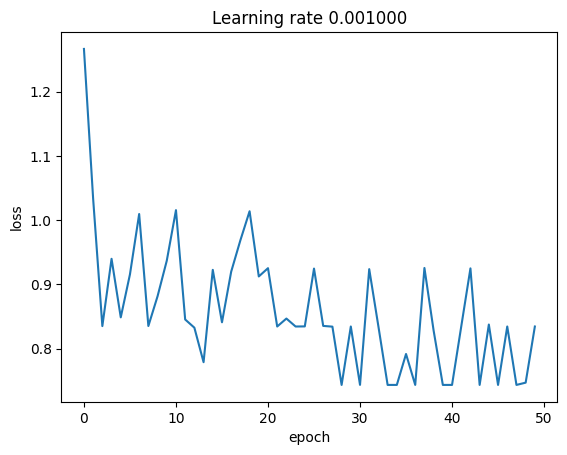

In [74]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [76]:
# test on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')


Accuracy of the network on the test images: 68.51496019763931%
